# Описание проекта

Маркетинговый аналитиз развлекательного приложения. Есть данные, необходимо с ними поработать.

# Цель проекта

Компания терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.

# Описание данных

Есть три датасета. 
1. visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
2. orders_info_short.csv — информацию о заказах, 
3. costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

# План работы

1. Посмотреть данные
2. Сформировать функции для расчета метрик и их визуализации
3. Формирование профиля клиента
4. Анализ данных
5. Рекомендации для компании

# Загрузка данных и подготовка к анализу

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from itertools import cycle
import os
from IPython.display import display_html

## Формирование функций

In [2]:
def missing_values(df):
    """Вычисление аномалий в датасете, включая минимальные и максимальные значения"""    
    data = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', 'unique_counts',\
                                          'min_value', 'max_value', 'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for column in df.columns:
        data['NaN_part'][column] = df[column].isnull().mean()
        data['empty_counts'][column] = df[df[column] == ''][column].count()
        data['space_counts'][column] = df[df[column] == ' '][column].count()
        data['0_counts'][column] = df[df[column] == 0][column].count()
        data['unique_counts'][column] = len(df[column].unique())
        data['min_value'][column] = df[column].min()
        data['max_value'][column] = df[column].max()
        data['dupl_sum'][column] = df[column].duplicated().sum()
        data['dtypes'][column] = df[column].dtypes
        data['length'][column] = len(df[column])
    return data 

In [19]:
def get_profiles(visits, orders, costs, events=pd.DataFrame(), event_names=[]):
    
    # находим параметры первых посещений
    profiles = (
        visits
        .sort_values(['user_id', 'session_start'])
        .groupby(by=['user_id'])
        .agg({
            'session_start': 'first',
            'region': 'first',
            'device': 'first',
            'channel': 'first'
        })
        .rename(columns={'session_start': 'first_dt'})
        .reset_index()
    )
    
    #для когортного анализа определяем дату первого посещения и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_dt'].astype('datetime64[D]')
    profiles['week'] = profiles['first_dt'].dt.isocalendar().week
    profiles['month_date'] = profiles['first_dt'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    
    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (
        profiles
        .groupby(by=['dt', 'channel'])
        .agg({'user_id':'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, how='left', on=['dt', 'channel'])
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения пользователя в профили
    profiles = profiles.merge(ad_costs, how='left', on=['dt', 'channel'])
    
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = np.where(
        profiles['channel'] == 'organic', 
        profiles['acquisition_cost'].fillna(0), 
        profiles['acquisition_cost']
    )
    
    #проверяем стоимость привлечения органических пользователей
    #print(profiles[profiles['acquisition_cost'].isnull()])
    
    return profiles

In [20]:
def get_retention(
    profiles,              #профили пользователей
    visits,                #журнал сессий
    observation_date,      #момент анализа
    horizon_days,          #горизонт анализа
    dimensions=[],         #столбец для группировки при расчете удержания
    ignore_horizon=False
):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")
    
    # Профили содержат информацию о первых визитах пользователей на сайт, но для расчёта Retention Rate нужны данные 
    # обо всех посещениях из журнала сессий.
    result_raw = result_raw.merge(visits[['user_id', 'session_start']], how='left', on='user_id')
    
    #расчитываем lifetime - время жизни пользователя
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_dt']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # строим таблицу удержания
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        #объединяем
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # делим данные таблицы удержания на размеры когорт
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем из результата все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # во время деления все значения cohort_size превратились в единицу
        result['cohort_size'] = cohort_sizes
        
        return result
    
    # получаем таблицу удержания
    result_by_payer = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_by_date = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
        
    return result_raw, result_by_payer, result_by_date

In [21]:
def get_conversion(
    profiles,              #профили пользователей
    orders,                #журнал покупок
    observation_date,      #момент анализа
    horizon_days,          #горизонт анализа
    dimensions=[],         #столбец для группировки при расчете удержания
    ignore_horizon=False
):
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")
    
    #первые заказы
    first_orders = (
        orders
        .sort_values(['user_id', 'event_dt'])
        .groupby(by='user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
    # Профили содержат информацию о первых посещениях пользователей, но для расчёта Conversion Rate нужны данные 
    # о первых заказах.
    result_raw = result_raw.merge(first_orders[['user_id', 'event_dt']], how='left', on='user_id')
    
    #расчитываем lifetime - время жизни пользователя
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_dt']).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # строим таблицу удержания
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        
        #Посчитать сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        #объединяем
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # делим данные таблицы удержания на размеры когорт
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем из результата все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # во время деления все значения cohort_size превратились в единицу
        result['cohort_size'] = cohort_sizes
        
        return result
    
    # получаем таблицу удержания
    result_by_payer = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []
    
    # получаем таблицу динамики удержания
    result_by_date = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
        
    return result_raw, result_by_payer, result_by_date

In [22]:
def get_ltv(
    profiles,              #профили пользователей
    orders,                #журнал покупок
    observation_date,      #момент анализа
    horizon_days,          #горизонт анализа
    dimensions=[],         #столбец для группировки при расчете удержания
    ignore_horizon=False
):
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")
    
    # Профили содержат информацию о первых визитах пользователей на сайт, но для расчёта Retention Rate нужны данные 
    # обо всех посещениях из журнала сессий.
    result_raw = result_raw.merge(orders, how='left', on='user_id')
    
    #расчитываем lifetime - время жизни пользователя
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_dt']).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # строим таблицу удержания
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        
        #Посчитать сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df
            .groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        #объединяем
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # делим данные таблицы удержания на размеры когорт
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем из результата все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # во время деления все значения cohort_size превратились в единицу
        result['cohort_size'] = cohort_sizes
        
         # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac
            .groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi
    
    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return (
        result_raw,      # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,     # таблица ROI
        roi_in_time,     # таблица динамики ROI
    )

In [23]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [24]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7, figsize=(20, 10)):

    # задаём размер сетки для графиков
    plt.figure(figsize=figsize)

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # если в индексах таблицы удержания только payer, добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title(f'Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title(f'Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    
    # получаем названия столбцов для сводной таблицы
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика удержания платящих пользователей по на {horizon}-й день')

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика удержания неплатящих пользователей на {horizon}-й день')
    
    plt.tight_layout()
    plt.show() 

In [25]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7, figsize=(20, 10)):

    # задаём размер сетки для графиков
    plt.figure(figsize=figsize)

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('CR')
    plt.title(f'Конверсия пользователей по {conversion.index.name}')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика конверсии пользователей по {conversion.index.name} на {horizon}-й день')

    plt.tight_layout()
    plt.show() 

In [26]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7, figsize=(20, 10)):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=figsize)

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title(f'LTV по {ltv.index.name}')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика LTV пользователей по {ltv.index.name} на {horizon}-й день')

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика стоимости привлечения пользователей по {ltv.index.name}')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title(f'ROI по {ltv.index.name}')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика ROI пользователей по {ltv.index.name} на {horizon}-й день')

    plt.tight_layout()
    plt.show() 

In [3]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df, title in zip(args, titles):
        html_str+='<td style="vertical-align:top">'
        html_str+=f'<h3><center>{title}<center></h3>'
        html_str+=df.to_html()
    display_html(html_str,raw=True)

## Загрузка и обработка данных

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [4]:
data = {} 
path = '/datasets/' if os.path.isdir('/datasets/' ) else 'datasets/'
columns = ['visits', 'orders', 'costs']
suffix = '_info_short'
for column in columns:
    data[column] = pd.read_csv(path + column + suffix + '.csv')
    
display_side_by_side(
    data['visits'].head(),
    data['orders'].head(),
    data['costs'].head(),

    titles=columns  
)

visits 
 
 
 
 User Id 
 Region 
 Device 
 Channel 
 Session Start 
 Session End 
 
 
 
 
 0 
 981449118918 
 United States 
 iPhone 
 organic 
 2019-05-01 02:36:01 
 2019-05-01 02:45:01 
 
 
 1 
 278965908054 
 United States 
 iPhone 
 organic 
 2019-05-01 04:46:31 
 2019-05-01 04:47:35 
 
 
 2 
 590706206550 
 United States 
 Mac 
 organic 
 2019-05-01 14:09:25 
 2019-05-01 15:32:08 
 
 
 3 
 326433527971 
 United States 
 Android 
 TipTop 
 2019-05-01 00:29:59 
 2019-05-01 00:54:25 
 
 
 4 
 349773784594 
 United States 
 Mac 
 organic 
 2019-05-01 03:33:35 
 2019-05-01 03:57:40 
 
 
 orders 
 
 
 
 User Id 
 Event Dt 
 Revenue 
 
 
 
 
 0 
 188246423999 
 2019-05-01 23:09:52 
 4.99 
 
 
 1 
 174361394180 
 2019-05-01 12:24:04 
 4.99 
 
 
 2 
 529610067795 
 2019-05-01 11:34:04 
 4.99 
 
 
 3 
 319939546352 
 2019-05-01 15:34:40 
 4.99 
 
 
 4 
 366000285810 
 2019-05-01 13:59:51 
 4.99 
 
 
 costs 
 
 
 
 dt 
 Channel 
 costs 
 
 
 
 
 0 
 2019-05-01 
 FaceBoom 
 113.3 
 
 
 1 
 2019-05-02 
 FaceBoom 
 78.1 
 
 
 2 
 2019-05-03 
 FaceBoom 
 85.8 
 
 
 3 
 2019-05-04 
 FaceBoom 
 136.4 
 
 
 4 
 2019-05-05 
 FaceBoom 
 122.1

In [5]:
visits, orders, costs = (
    pd.read_csv(path + 'visits_info_short.csv'),  # журнал сессий
    pd.read_csv(path + 'orders_info_short.csv'),  # покупки
    pd.read_csv(path + 'costs_info_short.csv'),  # траты на рекламу
)

In [6]:
missing_values(visits)

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
User Id,0.0,0,0,0,150008,599326,999999563947,159893,int64,309901
Region,0.0,0,0,0,4,France,United States,309897,object,309901
Device,0.0,0,0,0,4,Android,iPhone,309897,object,309901
Channel,0.0,0,0,0,11,AdNonSense,organic,309890,object,309901
Session Start,0.0,0,0,0,306813,2019-05-01 00:00:41,2019-10-31 23:59:23,3088,object,309901
Session End,0.0,0,0,0,306793,2019-05-01 00:07:06,2019-11-01 01:38:46,3108,object,309901


In [7]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])

In [8]:
missing_values(orders)

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
User Id,0.0,0,0,0,8881,599326,999895427370,31331,int64,40212
Event Dt,0.0,0,0,0,40163,2019-05-01 00:28:11,2019-10-31 23:56:56,49,object,40212
Revenue,0.0,0,0,0,5,4.99,49.99,40207,float64,40212


In [9]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

In [10]:
missing_values(costs)

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
dt,0.0,0,0,0,180,2019-05-01,2019-10-27,1620,object,1800
Channel,0.0,0,0,0,10,AdNonSense,lambdaMediaAds,1790,object,1800
costs,0.0,0,0,0,608,0.8,630.0,1192,float64,1800


In [11]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   Channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [13]:
visits = visits.rename(
    columns={
        'User Id': 'user_id',
        'Region': 'region',
        'Device': 'device',
        'Channel': 'channel',
        'Session Start': 'session_start',
        'Session End': 'session_end',
    }
)
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [14]:
orders = orders.rename(
    columns={
        'User Id': 'user_id',
        'Event Dt': 'event_dt',
        'Revenue': 'revenue'
    }
)
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [15]:
costs = costs.rename(
    columns={
        'Channel': 'channel'
    }
)
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [16]:
duplicateRows = visits[visits.duplicated()]
print(duplicateRows)

duplicateRows = orders[orders.duplicated()]
print(duplicateRows)

duplicateRows = costs[costs.duplicated(['dt', 'channel'])]
print(duplicateRows)

Empty DataFrame
Columns: [user_id, region, device, channel, session_start, session_end]
Index: []
Empty DataFrame
Columns: [user_id, event_dt, revenue]
Index: []
Empty DataFrame
Columns: [dt, channel, costs]
Index: []


In [17]:
print(f"Уникальные регионы: {visits['region'].unique()}")
print(f"Уникальные устройства: {visits['device'].unique()}")
print(f"Уникальные каналы: {visits['channel'].unique()}")

Уникальные регионы: ['United States' 'UK' 'France' 'Germany']
Уникальные устройства: ['iPhone' 'Mac' 'Android' 'PC']
Уникальные каналы: ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [18]:
print(f"Уникальные каналы: {costs['channel'].unique()}")

Уникальные каналы: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


## Исследовательский анализ данных

- Составить профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
- Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.

### Профили пользователей.

In [27]:
profiles = get_profiles(visits, orders, costs)
profiles = profiles[~(profiles['channel'] == 'organic')]
profiles.head()

,user_id,first_dt,region,device,channel,dt,week,month_date,payer,costs,unique_users,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,19,2019-05-01,True,101.2,93.0,1.088172
1,4919697,2019-07-09 12:46:07,United States,iPhone,FaceBoom,2019-07-09,28,2019-07-01,False,168.3,152.0,1.107237
3,22593348,2019-08-22 21:35:48,Germany,PC,AdNonSense,2019-08-22,34,2019-08-01,False,16.8,17.0,0.988235
4,31989216,2019-10-02 00:07:44,United States,iPhone,YRabbit,2019-10-02,40,2019-10-01,False,6.0,26.0,0.230769
7,46006712,2019-06-30 03:46:29,France,Android,AdNonSense,2019-06-30,26,2019-06-01,True,25.2,25.0,1.008000


In [28]:
min_date = profiles['first_dt'].min()
max_date = profiles['first_dt'].max()
print(f"Минимальная дата: {min_date.date()}")
print(f"Максимальная дата: {max_date.date()}")

Минимальная дата: 2019-05-01
Максимальная дата: 2019-10-27


Мы рассматриваем исторические данные от 1 мая 2019 года до 27 октября 2019 года. Это около полугода. 

Я убрал органические продажи, так как нам необходимо искать решение для рекламных компаний.

Имеются данные о регионе пользователя; устройства с которого он заходил; канала траффика и времени. Я разбил данные на платящих и неплатящих клиентов и получил стоимость привлечения одного уникального пользователя.

### Анализ региона

In [29]:
profiles_by_region = profiles.groupby(by=['region']).agg({'user_id': 'count', 'payer': 'mean'})
profiles_by_region

,user_id,payer
region,,
France,11058,0.050099
Germany,9528,0.051427
UK,11154,0.051013
United States,61829,0.098789


Сделал срез профиля пользователя по региону. Всего 4 страны пользуются приложением: Франция, Германия, Великобритания и США. Видно, что в США вомного больше пользователей, чем в Европе. При этом и доля платящих пользователей выше в США.

Можно уверенно утверждать, что в США приложением пользуются намного охотнее, чем в Европе. Возможно, оно было сделано под аудиторию американцев

### Анализ устройств

In [30]:
profiles_by_device = profiles.groupby(by=['device']).agg({'user_id': 'count', 'payer': 'mean'})
profiles_by_device

,user_id,payer
device,,
Android,21841,0.081590
Mac,18693,0.089499
PC,19153,0.067561
iPhone,33882,0.087716


Сделал срез профиля пользователя по устройству. Всего с 4 устройств пользуются приложением: Android, Mac, PC, iPhone. Видно, что с iPhone намного больше пользователей. Доля платящих пользователей выше для iPhone и Мас. Видимо более платежеспособны. С Android немного отстает. С PC реже всего покупают.

Если вспомнить, что больше всего пользователей из США, то этот феномен становится понятнее.

Можно уверенно утверждать, что раз большинство пользователей из США, то перевес оплат с iPhone and Mac будет прогнозируем в будущем.

### Анализ рекламных каналов

In [31]:
profiles_by_channel = (
    profiles
    .groupby(by=['channel'])
    .agg({'user_id': 'count', 'payer': 'mean', 'acquisition_cost': 'mean'})
    .sort_values(by='payer', ascending=False)
)

profiles_by_channel['payer'] = round(profiles_by_channel['payer'] * 100, 2)
profiles_by_channel['acquisition_cost'] = round(profiles_by_channel['acquisition_cost'], 2)

profiles_by_channel.rename(columns={'payer': 'payer, %'})

,user_id,"payer, %",acquisition_cost
channel,,,
FaceBoom,29144,12.20,1.11
AdNonSense,3880,11.34,1.01
lambdaMediaAds,2149,10.47,0.72
TipTop,19561,9.60,2.80
RocketSuperAds,4448,7.91,0.41
WahooNetBanner,8553,5.30,0.60
YRabbit,4312,3.83,0.22
MediaTornado,4364,3.57,0.22
LeapBob,8553,3.06,0.21


Сделал срез профиля пользователя по каналам. Всего с 11 каналов приходили в приложение. Больше всего приходит с органики, но они меньше всего платят. Они не мотивированы покупать.

Много приходит из FaceBoom and TipTop. С первого канала и самое большое количество оплат было. Со второго поменьше, но достаточно много. Но стоимость привлечения с TipTop намного выше, она самая дорогая.

По цене-качеству самый лучший канал FaceBoom. TipTop привлекает много, но дорого. Есть каналы, такие как LeapBob, OppleCreativeMedia, которые привлекают много (сильно уступая лидерам), но и стоимость привлечения у них очень низкая.

## Маркетинг

- Посчитать общую сумму расходов на маркетинг.
- Выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построить визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

### Общие расходы

In [32]:
print(f"Общие расходы на маркетинг: {costs['costs'].sum()}")
print(f"Общая прибыль: {orders['revenue'].sum()}")

Общие расходы на маркетинг: 105497.30000000002
Общая прибыль: 215962.88


В целом видно, что кампания окупается, доходы превышают расходы в 2 раза. Должно быть причина убытков в неправильном использовании ресурсов. 

Продолжу анализ

### Расходы по каналам

In [33]:
df = costs.groupby(by=['channel']).agg({'costs': 'sum'}).sort_values(by=['costs'])
df['part, %'] = df['costs'] / df['costs'].sum() * 100
df

,costs,"part, %"
channel,,
YRabbit,944.22,0.895018
MediaTornado,954.48,0.904744
lambdaMediaAds,1557.60,1.476436
LeapBob,1797.60,1.703930
RocketSuperAds,1833.00,1.737485
OppleCreativeMedia,2151.25,2.039152
AdNonSense,3911.25,3.707441
WahooNetBanner,5151.00,4.882589
FaceBoom,32445.60,30.754910


Сделал срез затрат на рекламу каналам. Всего с 11 каналов приходили в приложение. Наиболее дорогой канал оказался TipTop. По нему и стоимость привлеченного пользователя самая дорогая. Faceboom, хоть и очень эффективный, но дорогой канал. 

LeapBob, OppleCreativeMedia - мало потратили. Если увеличить траты, то увеличится количество новых дешевых пользователей. 

YRabbit, MediaTornado крайне мало потратили и стоимость привлечения новых пользователей очень низкая.

В WahooNetBanner много потратились, а результат хуже, чем в LeapBob. Траты в AdNonSense и lambdaMediaAds также малоэффективны.

Предложил бы снизить траты на AdNonSense, lambdaMediaAds и WahooNetBanner. Увеличить в первую очередь на LeapBobб OppleCreativeMedia и чуть меньше на YRabbit, MediaTornado

Снизить траты на TipTop и переложить их в FaceBoom.

Все это в рамках оптимизации затрат. В целом кампания, как говорил уже, прибыльная. Можно ничего не менять, а больше тратить на рекламу в тех же пропорциях.

### Динамика расходов по каналам.

In [34]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month#_name()
costs.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


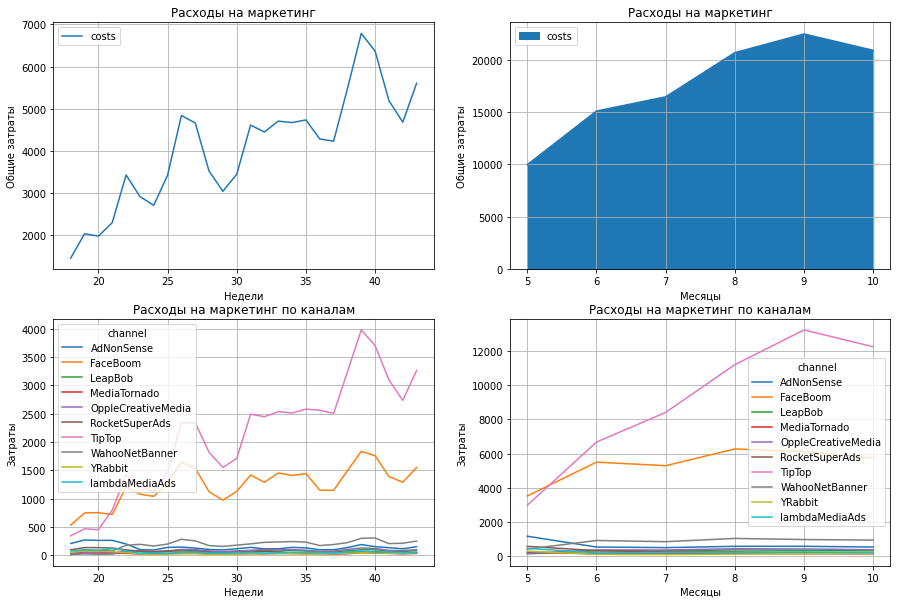

In [35]:
plt.subplots(figsize = (15, 10))

costs.groupby(by=['week']).agg({'costs': 'sum'}).plot(grid=True, ax=plt.subplot(2,2,1))
plt.xlabel('Недели')
plt.ylabel('Общие затраты')
plt.title('Расходы на маркетинг')

costs.groupby(by=['month']).agg({'costs': 'sum'}).plot.area(grid=True, ax=plt.subplot(2,2,2))
plt.xlabel('Месяцы')
plt.ylabel('Общие затраты')
plt.title('Расходы на маркетинг')

costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=plt.subplot(2,2,3))
plt.xlabel('Недели')
plt.ylabel('Затраты')
plt.title('Расходы на маркетинг по каналам')

costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=plt.subplot(2,2,4))
plt.xlabel('Месяцы')
plt.ylabel('Затраты')
plt.title('Расходы на маркетинг по каналам')

plt.show()

Расходы растут, тренд восходящий. По неделям видны провалы, видимо связаны с летним периодом. Резкий рост в сентябре с небольшим провало в октябре. Последние 3 месяца виден выход на плато по месячным расходам. В октябре было снижение расходов на рекламу. 

В разрезе по каналам видны резко высокие расходы на FaceBoom and TipTop. Расходы на FaceBoom стабилизировались на высоком уровне с 25 недели, на TipTop стабильно росли до ~40 недели. На месячном графике видно, что расходы на FaceBoom c агуста начали незначительно падать, на TipTop только в сентябре. В обоих случаях видны аномальные траты относительно других каналов.

Стабилизация расходов на FaceBoom and TipTop связана видимо как раз с тем, что компания ощутила убыток от роста затрат на маркетинг и обратилась ко мне)

### Стоимость привлечения одного пользователя

In [36]:
profiles.groupby(by=['channel']).agg({'acquisition_cost': 'mean'}).sort_values(by=['acquisition_cost'], ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Сделал разрез пользователей по каналам. Видно, что самые дорогие пользователи из TipTop. Я бы даже сказал, что слишком дорогие: в 2.5 раз больше, чем на следующего по тратам FaceBoom.

## Окупаемость рекламы

Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализировать окупаемость рекламы.
- Проверить конверсию и удержание пользователей и динамику изменения.
- Проанализировать окупаемость рекламы с разбивкой по устройствам. 
- Проанализировать окупаемость рекламы с разбивкой по странам. 
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам. 

### Анализ общей окупаемости рекламы

In [37]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Сначала посмотрим на окупаемость рекламы в целом, без разрезов по группам.

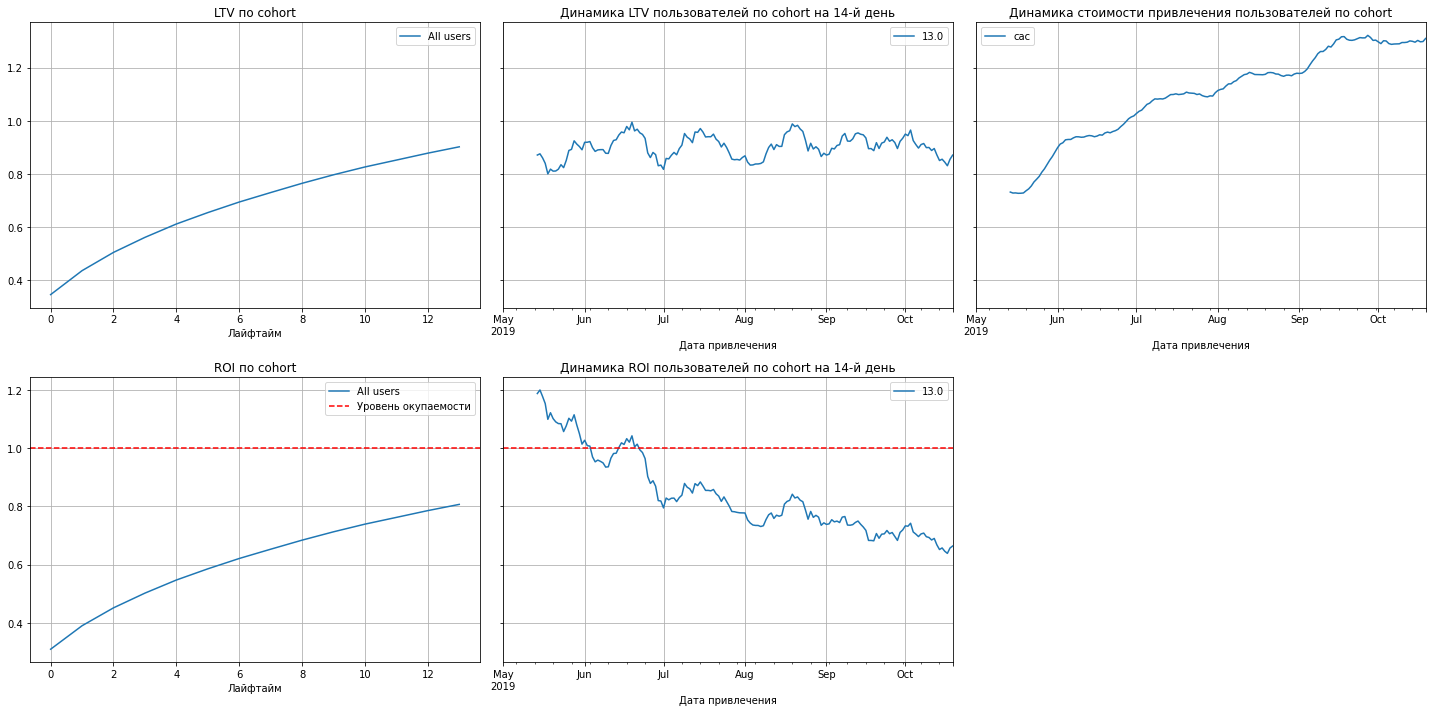

In [38]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders, 
    observation_date,
    horizon_days,     
    dimensions=[],        
    ignore_horizon=False
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Из графиков LTV, ROI, CAC видно, что реклама вообще не окупается:
1. CAC растет все эти полгода. Значит дело в увеличении рекламного бюджета.
2. Динамика LTV стабильна на 14 день. Значит дело не в ухудшении качества пользователя.
3. LTV растет до 90% к 14 дню.
3. ROI в мае был больше 100% на 14 день, но к октябрю падает до 60%. Видимо связано с ростом САС.

### Анализ конверсии и удержания пользователей и динамики их изменения. 

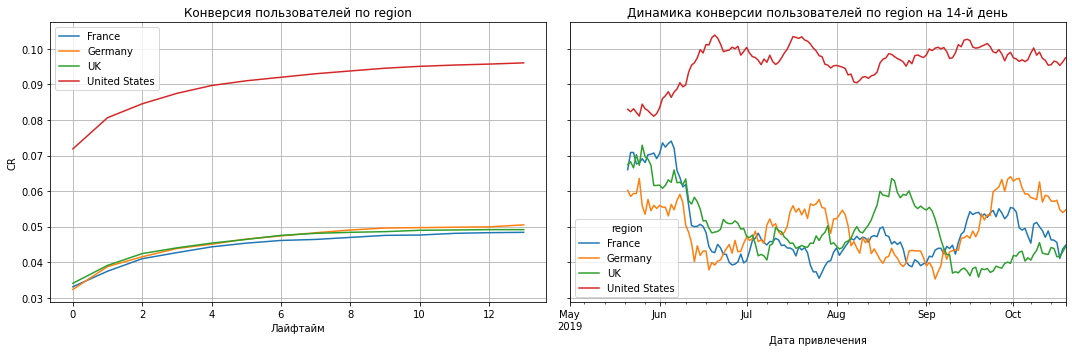

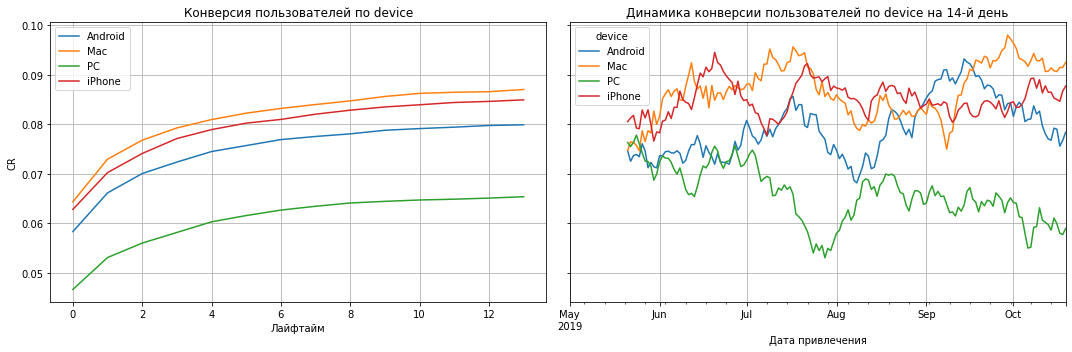

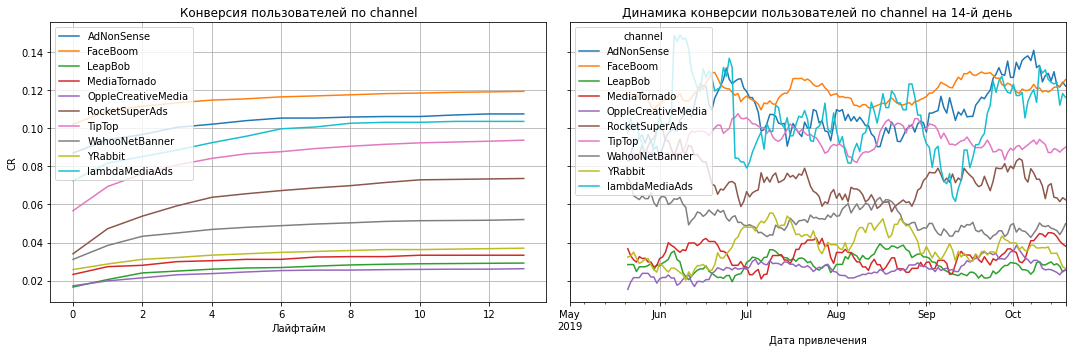

In [39]:
columns = ['region', 'device', 'channel']
for column in columns:
    conversion_raw, conversion, conversion_history = get_conversion(
        profiles, 
        orders, 
        observation_date, 
        horizon_days, 
        dimensions=[column]
    )

    plot_conversion(conversion, conversion_history, horizon_days, window=21, figsize=(15, 5))

Конверсия по регионам намного выше в США, чем в Европе. Динамика конверсии тоже лучше. В США явно охотнее пользуются продуктом, хотят его покупать. 

Чаще делают заказы с iPhone and Mac. Немного отстает андроид и вообще сильно отстает ПК. Все-таки чаще делают заказы с мобильных устройств. Динамика конверсии в целом имеет сезонность, но стабильна.

Хорошо конвертируются в FaceBoom, AdNonSense, lambdaMediaAds. Чуть хуже TipTop. Еще хуже RocketSuperAds, WahooNetBanner. Остальные совсем плохо.

Динамика конверсии в целом стабильна, только разное влияние сезонности у каждого канала.

Теперь понятно, почему возникли проблемы у компании. Она побежала за конверсией, но не обратила внимание на ROI. 

Предложенные мною каналы для продвижения компании имеют плохую конверсию. Пожалуй кроме lambdaMediaAds, плюс он имеет высокую сезонность. Посмотрим на график удержания

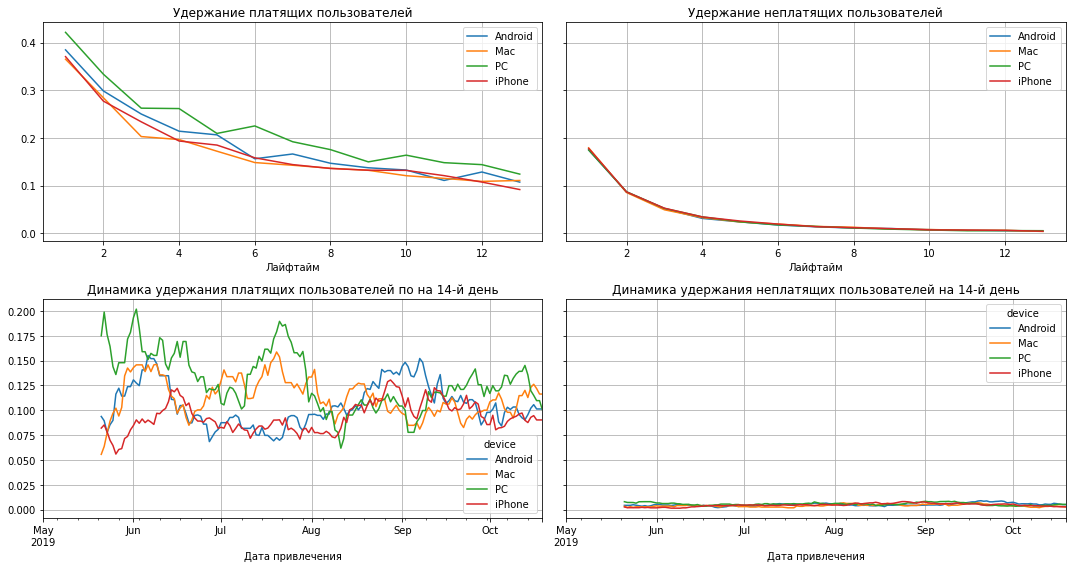

In [40]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['device']
)

plot_retention(retention, retention_history, horizon_days, window=21, figsize=(15, 8))

Рассмотрим удержание пользователей в разрезе устройств.

Нас интересуют платящие пользователи, раз мы терпим убытки. Из ПК удержание самое сильное. То есть покупают с ПК реже, но остаются стабильнее дольше. Это связано скорее всего с тем, что с телефонов сидят в бегах, некогда разбираться. С ПК же в более спокойной обстановке, поэтому и стабильно дольше остаются.

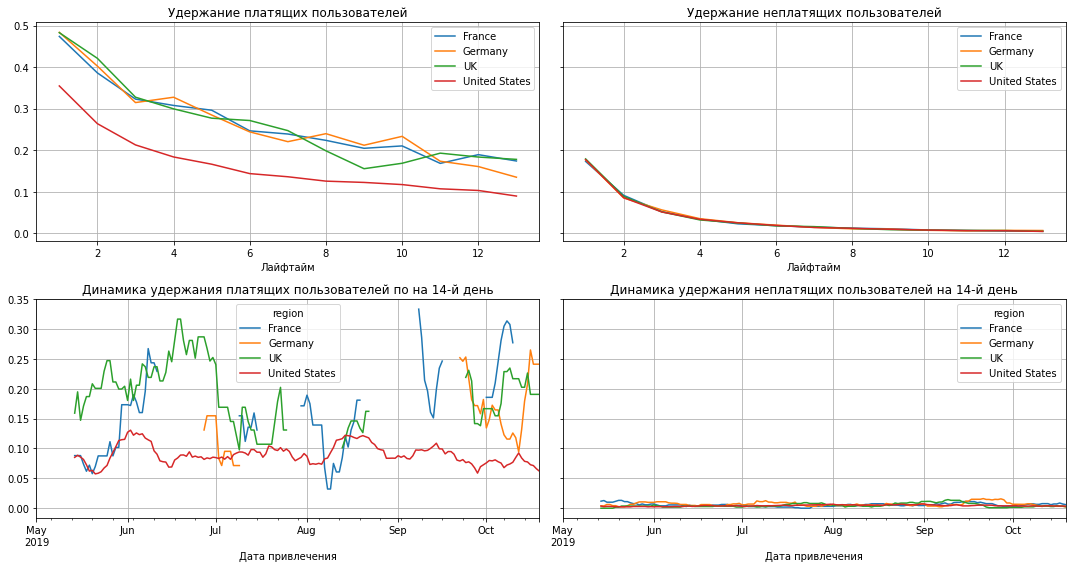

In [41]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['region']
)

plot_retention(retention, retention_history, horizon_days, window=14, figsize=(15, 8))

Рассмотрим для начала удержание пользователей в разрезе регионов.

Нас интересуют платящие пользователи, раз мы терпим убытки. Из верхнего левого графика видно, что удержание в США ниже, чем в Европе. То есть конверсия в США сильно выше, но удержание сильно ниже. Это говорит о некоторой спекулятивности, волатильности продаж в Америке. Возможно волна хайпа. Не получается удержать аудиторию при хорошей конверсии. Значит ожидания покупателей не соответствуют реальности.

Динамика удержания для США так же ниже, чем для Европы.

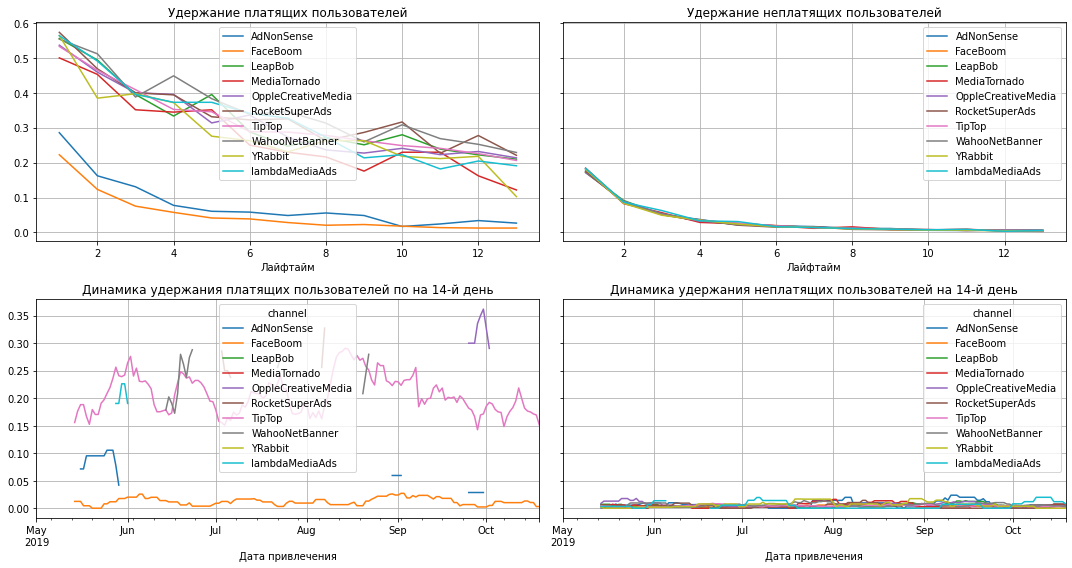

In [42]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions=['channel']
)

plot_retention(retention, retention_history, horizon_days, window=14, figsize=(15, 8))

Рассмотрим удержание пользователей в разрезе каналов.

Нас интересуют платящие пользователи, раз мы терпим убытки. Из верхнего левого графика видно, что удержание из FaceBoom and AdNonSense резко ниже, чем по остальным каналам.

По динамике удержания вообще интересно: органика и TipTop намного лучше удерживаются, чем FaceBoom. Остальные почему-то отрывками отрисовываются в зависимости от размера окна сглаживания. Так и не понял почему. Видимо очень мало когорт по дням. Но график все равно же должен был быть.

### Анализ окупаемости рекламы по регионам. 

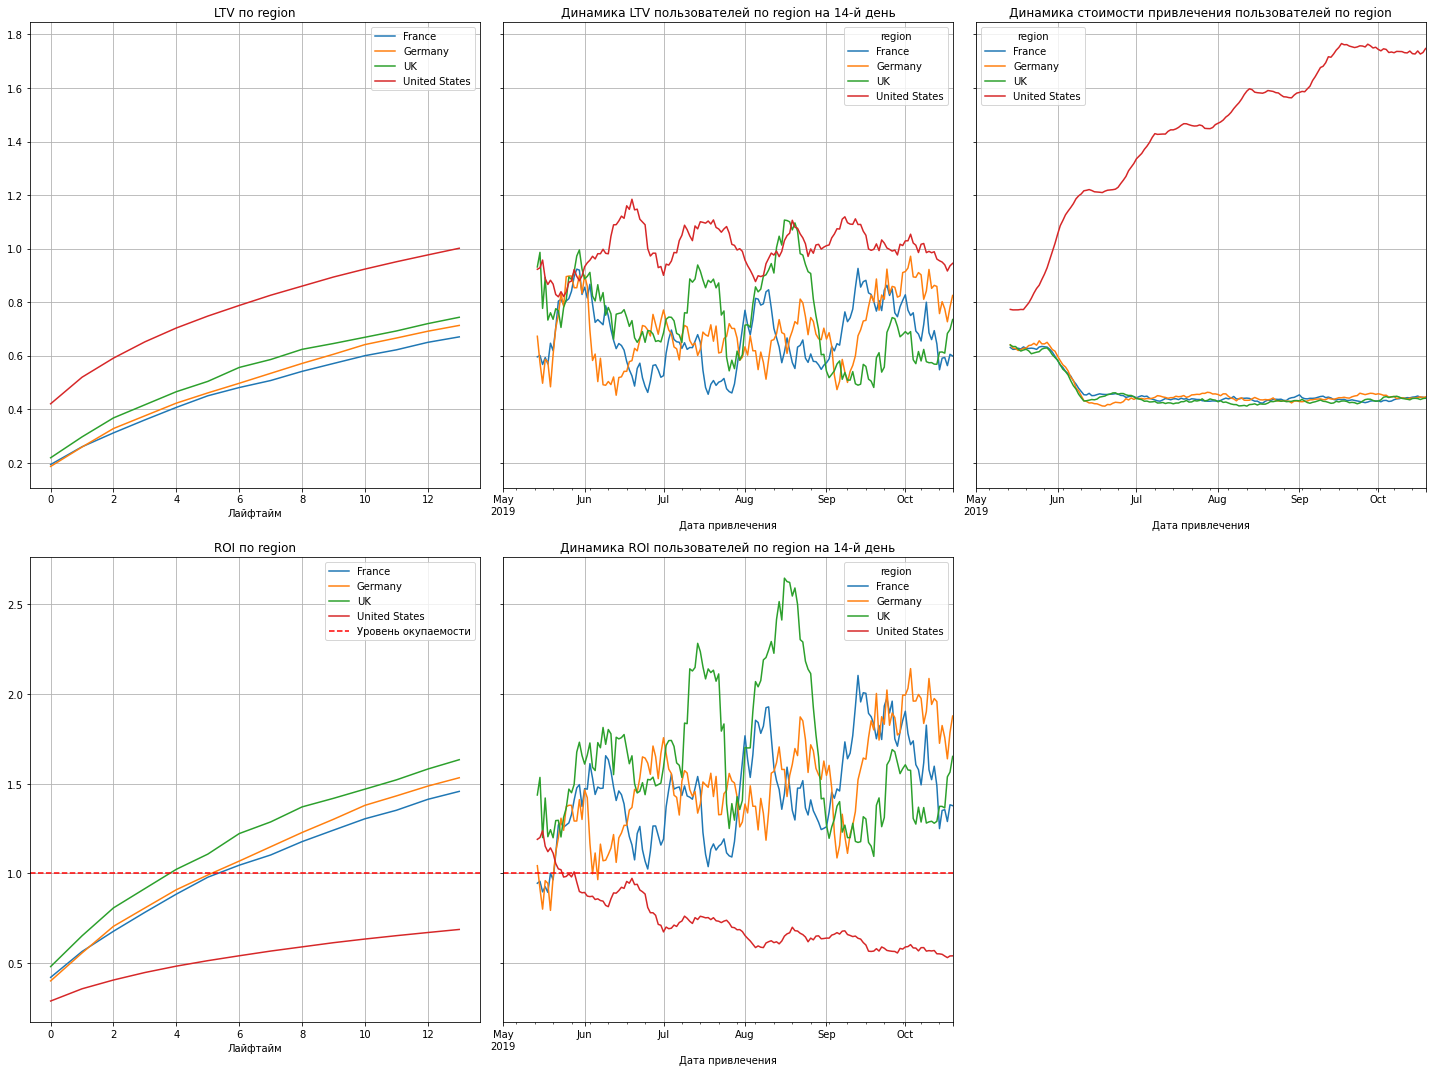

In [43]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders, 
    observation_date,
    horizon_days,     
    dimensions=['region'],        
    ignore_horizon=False
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14, figsize=(20,15))

Ни в одном регионе нет окупаемости:
1. LTV самый высокий у США.
2. Динамика LTV за 14 дней стабильна, но только в США стабильно выше 1.
3. Стоимость привлечения пользователя растет именно в США. Значит проблема в этом регионе. В Европе она в целом стабильна, хотя в июне здесь наблюдалось падение. Видимо перераспределили деньги из Европы в США.
4. Для Европы динамика ROI стабильна выше 100%, лучше всего до сентября работала в UK, с сентября в Германии и Франции. Картину ухудшает ситуация в США - здесь метрика падает до 50%.

Визуально видно, что лучший LTV в США, но в Америке растет и САС, поэтому ROI падает большими темпами.

Из динамики ROI за 14 дней видно, что стабильно держится только Европа.

Вывод такой: плохие дела в США. Почему-то деньги перераспределили из Европы в США. В первую очередь надо работать с маркетингом в Америке, чтобы стабилизировать ситуацию.

Рассмотрю ситуацию в разрезе по устройствам

### Анализ окупаемости рекламы по устройствам.

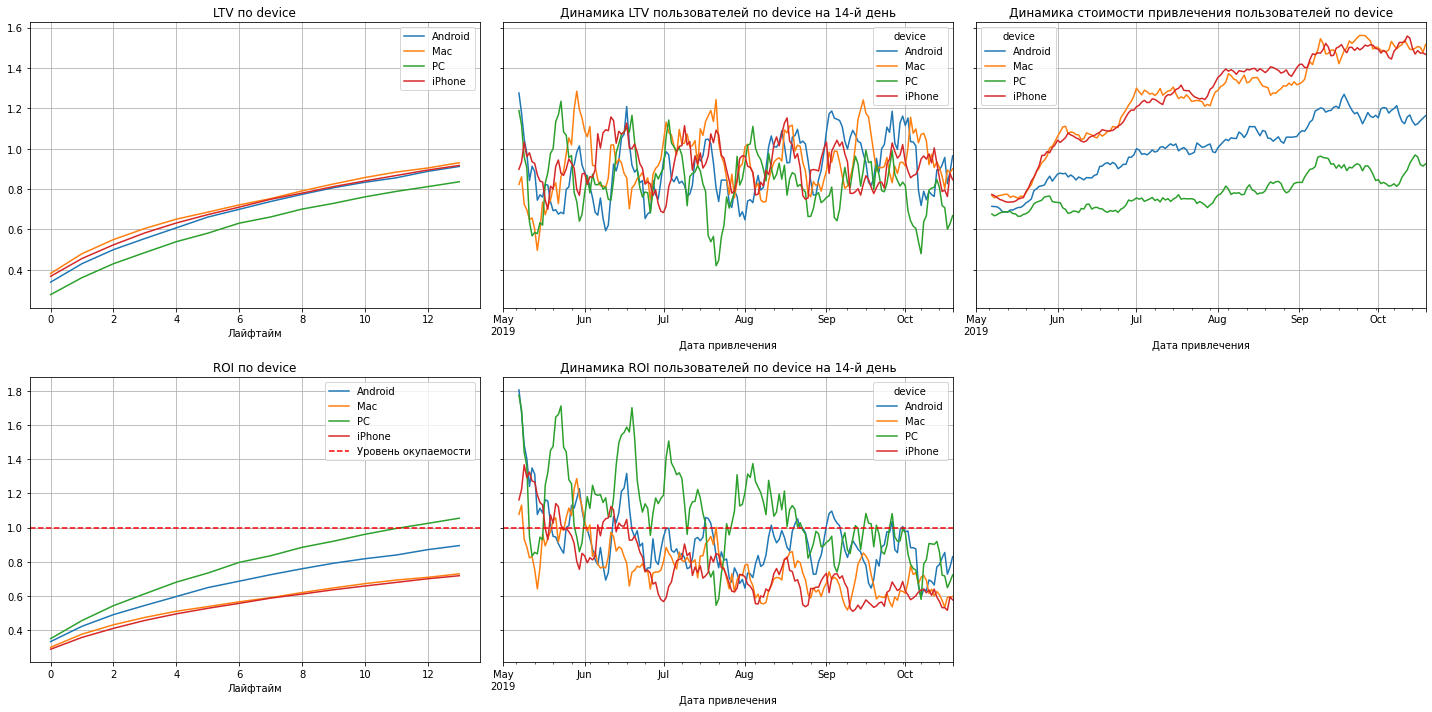

In [44]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders, 
    observation_date,
    horizon_days,     
    dimensions=['device'],        
    ignore_horizon=False
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

По устройствам так же нет окупаемости:
1. Динамика LTV стабильно - дело не в ухудшении качества пользователей.
2. САС растет на всех устройствах. Меньше всего рост на ПК. Значит проблема не связана с ними. Рекламу льют везде одинаково много. Но больший рост на iPhone and Mac.
3. Самый высокий уровень окупаемости на ПК. К 12 дню продажи через ПК окупаются. Чуть отстает андроид. Одинаково плохо на iPhone and Mac.
4. Двухнедельная динамика ROI ухудшается и к октябрю перестает перестает окупаться.

Рассмотрю данные в разрезе по каналам

### Анализ окупаемости рекламы по рекламным каналам.

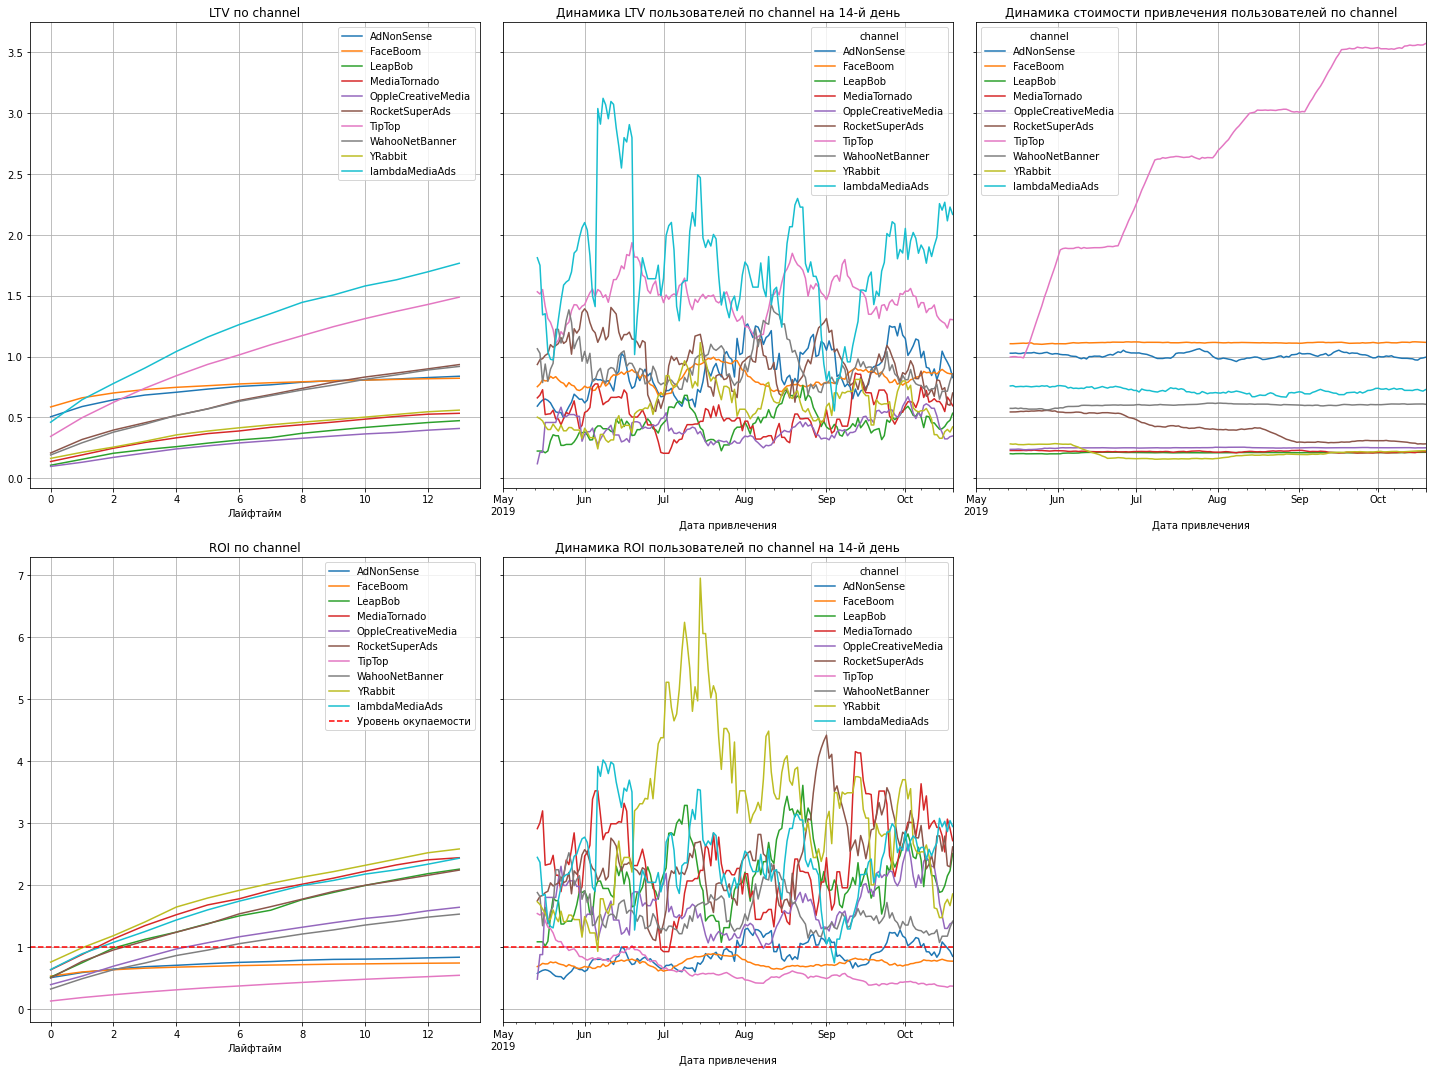

In [45]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders, 
    observation_date,
    horizon_days,     
    dimensions=['channel'],        
    ignore_horizon=False
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14, figsize=(20, 15))

Как и предполагалось ранее видны огромные затраты на TipTop. Ни по одному каналу не окупаются затраты:
1. LTV хороший у lambdaMediaAds and TipTop
2. Динамика LTV стабильна - дело не в ухудшении качества пользователей. Есть некоторая сезонность.
3. САС резко растет для канала TipTop. Надо отказываться от него быстро.
4. Окупаются все каналы кроме AdNonSense, FaceBoom, TipTop. Надо от них отказываться.
5. Наилучшая динамика ROI у YRabbit. У него и стоимость привлечения пользователя была низкой.

В целом в разрезе по устройствам картина одинакова. Необходимо обращать внимания на разрез по каналам и отдельно посмотреть на регион США. Здесь почему-то большие проблемы.

Какая связь между США и расходами на рекламу по каналам? Рассмотрим

In [46]:
profiles_reg_channel = (
    profiles
    .groupby(by=['region', 'channel'])
    .agg({'user_id': 'count', 'payer': 'mean', 'acquisition_cost': 'mean'})
)

profiles_reg_channel

user_id     payer  acquisition_cost
region        channel                                                
France        AdNonSense             1366  0.109810          1.007553
              LeapBob                2988  0.030120          0.210189
              OppleCreativeMedia     2991  0.026747          0.249862
              WahooNetBanner         2971  0.051161          0.602200
              lambdaMediaAds          742  0.110512          0.721211
Germany       AdNonSense             1219  0.116489          1.008435
              LeapBob                2519  0.027392          0.210380
              OppleCreativeMedia     2562  0.024980          0.250091
              WahooNetBanner         2579  0.057387          0.602161
              lambdaMediaAds          649  0.103236          0.726176
UK            AdNonSense             1295  0.114286          1.008224
              LeapBob                3046  0.033815          0.209983
              OppleCreativeMedia     3052  0.029161          0.250059
              WahooNetBanner         3003  0.050949          0.602361
              lambdaMediaAds          758  0.100264          0.727142
United States FaceBoom              29144  0.122049          1.113286
              MediaTornado           4364  0.035747          0.218717
              RocketSuperAds         4448  0.079137          0.412095
              TipTop                19561  0.096007          2.799003
              YRabbit                4312  0.038265          0.218975

А вот и ответ. Только в США использовали самый дорогой TipTop канал, а заодно и самый неэффективный Faceboom. AdNonSense мешает получить лучшую окупаемость в Европе, стоит от него отказаться.

Предварительные выводы.
1. Отключать рекламу на TipTop и FaceBoom в США. Это стабилизирует ситуацию в этом регионе.
2. В Европе надо отказаться от AdNonSense. Предварительно предлагаю оставлять только 5 каналов - YRabbit, MediaTornado, lambdaMediaAds, RocketSuperAds, LeapBob. Осторожно пробовать OppenCreativeMedia, WahooNetBanner. Искать другие источники траффика.

### Выводы

<strong>Окупается ли реклама, направленная на привлечение пользователей в целом?</strong>

Нет не окупается. Достигает 80% к концу второй недели.

<strong>Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?</strong>

по регионам США оказывает негативное влияние. Только там используются каналы TipTop and FaceBoom. Оба канала очень дорогие. Траты на TipTop надо резко снижать или вообще отказываться, так как САС резко вырос. Это говорит о том, что деньги тратятся впустую: от вливания бюджета количество новых пользователей не увеличивается.

Устройства не оказывают негативного влияния на окупаемость рекламы. Можно только уточнить, что чуть большее негативное влияние имеет iPhone and Mac. Но это скорее всего связано с проблемой в регионе США.

Рекламные каналы влияют, больше 80% расходов ушло на FaceBoom and TipTop в США. Необходимо отказываться от AdNonSense, TipTop and FaceBoom. Они дорогие, не окупаются. Рекламу надо оплачивать равномернее по регионам.

<strong>Чем могут быть вызваны проблемы окупаемости?</strong>

Все деньги вбухали в один регион США и в 2 канала: FaceBoom and TipTop. В Европе можно улучшить ситуацию отказавшись от AdNonSense.

<strong>Причины неэффективности привлечения пользователей</strong>

Мы рассматриваем исторические данные от 1 мая 2019 года до 27 октября 2019 года. Это около полугода.

Сделал срез профиля пользователя по региону. Всего 4 страны пользуются приложением: Франция, Германия, Великобритания и США. Видно, что в США вомного больше пользователей, чем в странах Европы (примерно в 3 раза). При этом и доля платящих пользователей выше в США (примерно на 3%).

Можно уверенно утверждать, что в США приложением пользуются намного охотнее, чем в Европе. Как оказалось потому что 80% расходов уходило в США. Так как большинство пользователей из США, то поэтому чаще заходят с iPhone and Mac. Конверсия выше в США, но при этом в Америке удержание ниже остальных регионов. Это говорит о плохом качестве пользователей в США.

Много приходит из FaceBoom and TipTop. С первого канала и самое большое количество оплат было. Со второго поменьше, но достаточно много. Но стоимость привлечения с TipTop намного выше второго по дороговизне (примерно в 2.5 раза), она самая дорогая. FaceBoom тоже дорогой канал. В Европе ухудшает картину AdNonSense, вероятно стоит от него отказаться.

Чаще всего заходя с iPhone. В целом с iPhone and Mac приходит больше платящих пользователей примерно на 1%.

Больше всего денег ушло на рекламу в FaceBoom (30%) and TipTop (51%). Каналы эти оплачивались только в регионе США. То есть 80% всех расходов за полгода было направлено на рекламу в США по каналам FaceBoom and TipTop. На остальные каналы ушло до 5% расходов на каждый. На Европу соответственно денег выделено было мало, хотя она прибыльна, в отличие от США. Месячные расходы за полгода выросли в 2 раза. 

Самая большая цена привлечения пользователя у AdNonSense(1.0$), FaceBoom(1.1$) and TipTop(2.8$).

Хорошо конвертируются в FaceBoom, AdNonSense, lambdaMediaAds. Чуть хуже TipTop. По регионам это США. По устройствам iPhone and Mac.

По устройствам удержание лучше всего у ПК и андроид. По регионам сильно отстают США. По каналам - FaceBoom and AdNonSense. Общий ROI около 80. По регионам самый низкий у США. По устройствам у iPhone and Mac. По каналам TipTop, FaceBoom and AdNonSense

<strong>Рекомендации для отдела маркетинга</strong>

В целом надо сделать упор на сильные стороны и убрать слабые.

По регионам: 
1. Значительно снизить объем расходов на рынок США.
2. Сделать больший акцент на рынки Европы, так как реклама там окупается.

По каналам:
1. Сильно уменьшить траты по каналам TipTop, FaceBoom and AdNonSense. Сделать больший акцент на другие более дешевые каналы.
2. Необходимо пересмотреть пропорцию трат на каналы. К примеру на YRabbit повысить, на AdNonSense снизить

По устройствам:
1. В целом все хорошо, можно только сделать больший акцент на продажи с ПК и андроид, там стабильно выше удержание.